In [3]:
:sccache 1
// Skip this or run `cargo install sccache`

sccache: true


In [4]:
:dep z3tracer
// Or use `:dep z3tracer = { path = ".." }` for the local version.

In [5]:
:dep plotly

In [6]:
:efmt {:?}

Error format: {:?} (errors must implement std::fmt::Debug)


In [7]:
:opt 3

Optimization: 3


In [8]:
use z3tracer::{syntax::*, model::*};
use std::collections::*;
use std::str::FromStr;
use plotly::*;
use plotly::common::*;
use plotly::layout::*;

In [ ]:
:last_error_json
// BUG WORKAROUND: In case of mysteriously truncated error 'consider importing this struct', run the command above again
// to print a detailed error and find the import that is actually missing.
//
// See also :help for more useful commands

In [10]:
/// Helper function to process files.
fn process_file(path: &str) -> std::io::Result<Model> {
    let file = std::io::BufReader::new(std::fs::File::open(path)?);
    // Inject non-default configurations here with Model::new(config).
    let mut model = Model::default();
    if let Err(le) = model.process(Some(path.to_string()), file) {
        println!("Error at {:?}: {:?}", le.position, le.error);
    }
    Ok(model)
}

/// Helper trait to print es by their id.
trait ModelExt {
    fn id2s(&self, id: &Ident) -> String;    
}

impl ModelExt for Model {
    fn id2s(&self, id: &Ident) -> String {
        self.id_to_sexp(&BTreeMap::new(), id).unwrap()
    }        
}

In [11]:
// Process some input file obtained with `z3 trace=true proof=true ..`
let model = process_file("../tests/data/file1.log")?;

In [12]:
// Compute top instantiated terms.
let mut top = model.most_instantiated_terms();
top.len()

46

In [13]:
// Retrieve the "timestamps" at which instantiations occur for each of the top terms.
let instantiation_times = top.iter().map(|(_count, id)| {
    let mut timestamps = model.term_data(id).unwrap().instantiations.iter().filter_map(|key| {
        let qi = model.instantiations().get(key).unwrap();
        qi.data.as_ref().map(|d| model.term_data(&d.term).unwrap().timestamp)
    }).collect::<Vec<_>>();
    timestamps.sort();
    let name = match model.term(id).unwrap() { Term::Quant { name, .. } => name, _ => "??" };
    (name.to_string(), timestamps)
}).collect::<Vec<_>>();

In [14]:
// Maximum timestamp (i.e. currently, the number of lines in the Z3 log)
let max_ts = model.processed_logs();
max_ts

443166

In [15]:
// Maximum number of instantiations for the top term.
let max_count = top.peek().unwrap().0;
max_count

359

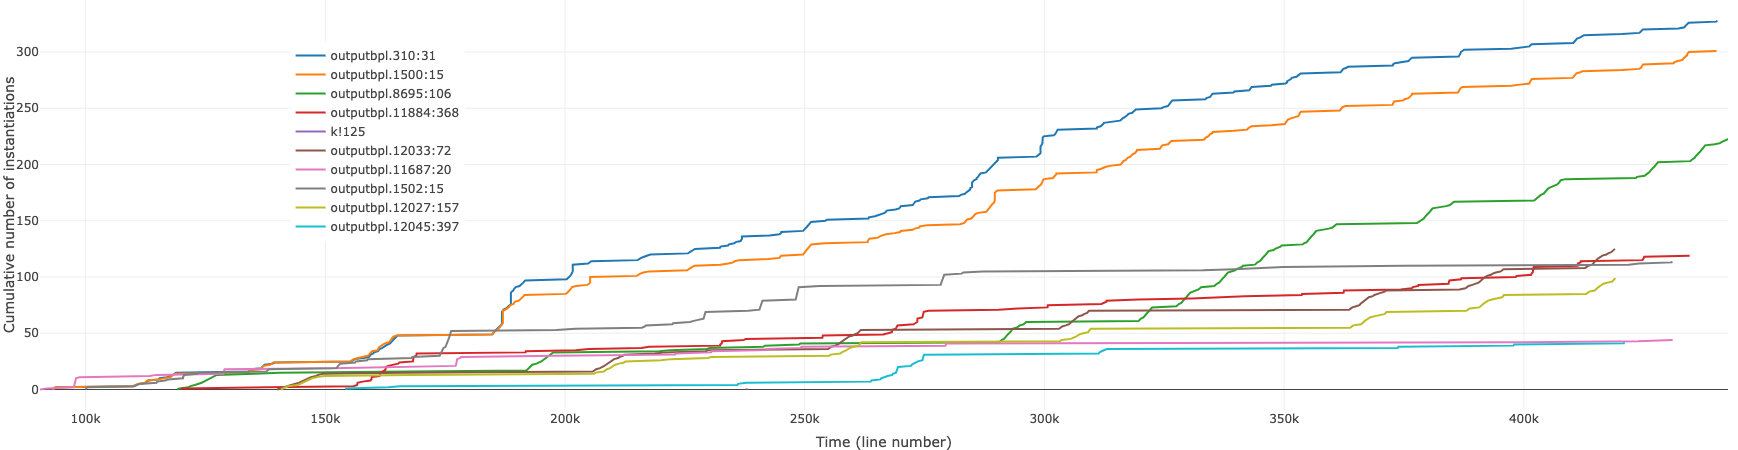

In [16]:
let layout = Layout::new()
    .x_axis(Axis::new().title(Title::new("Time (line number)")))
    .y_axis(Axis::new().title(Title::new("Cumulative number of instantiations")))
    .margin(Margin::new().top(0).bottom(40).left(40).right(10))
    .legend(Legend::new().x(0.2).y(0.9).orientation(Orientation::Vertical).x_anchor(Anchor::Center));

let mut plot = Plot::new();
plot.set_layout(layout);

for (name, values) in instantiation_times.iter().take(10) {
    let (ys, xs) : (Vec<_>, Vec<_>) = values.iter().cloned().enumerate().unzip();
    let trace = Scatter::new(xs, ys).name(name).mode(Mode::Lines);
    plot.add_trace(trace);
}

plot.lab_display();

In [17]:
// Top instantiated quantified term.
model.id2s(&top.peek()?.1)

"(QUANT ((v2 T@$Value) (v1 T@$Value)) (! (not (or (not (or ($IsEqual_stratified v1 v2) (not (or (= v1 v2) (not (or (not (= (l#$ValueArray (v#$Vector v1)) (l#$ValueArray (v#$Vector v2)))) (not (is v1)) (not (is v2)) (not (or ($IsEqual_level1 (Select_[$int]$Value (v#$ValueArray (v#$Vector v1)) (i!8!0 v2 v1)) (Select_[$int]$Value (v#$ValueArray (v#$Vector v2)) (i!8!0 v2 v1))) (<= (+ (l#$ValueArray (v#$Vector v1)) (* (- 1) (i!8!0 v2 v1))) 0) (not (>= (i!8!0 v2 v1) 0)))))))))) (not (or (= v1 v2) (not ($IsEqual_stratified v1 v2)) (not (or (not (= (l#$ValueArray (v#$Vector v1)) (l#$ValueArray (v#$Vector v2)))) (not (is v1)) (not (is v2)) (not (QUANT ((i Int)) (! (or ($IsEqual_level1 (Select_[$int]$Value (v#$ValueArray (v#$Vector _2)) i) (Select_[$int]$Value (v#$ValueArray (v#$Vector v1)) i)) (>= (+ i (* (- 1) (l#$ValueArray (v#$Vector _2)))) 0) (not (>= i 0))) :qid outputbpl.315:14 :pattern (pattern (Select_[$int]$Value (v#$ValueArray (v#$Vector _2)) i)) :pattern (pattern (Select_[$int]$Value

In [18]:
// Final counter and `Ident` value for the top term.
top.peek()?

(359, #4429!9)

In [19]:
// Introspect a particular term, given by handle.
// Note that the version number `!9` was added during parsing for disambiguation and is not present in the original log file.
model.term(&Ident::from_str("#4429!9")?)?

Quant { name: "outputbpl.310:31", params: 2, triggers: [#284], body: #4443, var_names: Some([VarName { name: Symbol("v2"), sort: Symbol("T@$Value") }, VarName { name: Symbol("v1"), sort: Symbol("T@$Value") }]) }

In [20]:
let qt = model.term(&Ident::from_str("#4429!9")?)?.clone();

In [21]:
model.id2s(&Ident::from_str("#257!1")?)

"($IsEqual_stratified _1 _0)"

In [22]:
use z3tracer::syntax::Term::Quant;

(match qt { Term::Quant { triggers, .. } => Some(model.id2s(&triggers[0])), _ => None })?

"(pattern ($IsEqual_stratified _1 _0))"